In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit

# MDP Interfaces

This notebook is intended to demonstrate a lightweight way to represent an MDP in Python.

It is intended to be a very _general_ representation which is both:
 - clean and easy to understand
 - general enough to have powerful functionality in special cases

## Model Variables

At the core of any MDP are model variables. There are many types of model variables. These include:

* **State variables**. State variables can be reassigned at each time step. A state variable has a *transition function*, which is a function of other variables (and possibly itself).
* **Control variables**. Control variables are controlled by an agent. The model does not contain a transition function for them. But it is known what other variables--its *parents* or *dependencies* or *inputs*--a control variable may depend on. A *decision rule* induces into a control variable a function, whose domain is the Cartesian product of its parents, that works like a transition function.
* **Exogenous variables**. Exogenous variables are randomly sampled at each time step, but their values do not persist like state variables.

In [2]:
class Variable():
    # List of strings, the names of variables
    value = None
    parents = []
    
    def __init__(self, parents, value=None):
        self.value = value
        self.parents = parents
        self.history = []

    def update_value(self, model):
        self.history.append(self.value)
        return self.value
        
class StateVariable(Variable):
    def __init__(self, parents, transition, value=0):
        super().__init__(parents, value=value)
        self.transition = transition
    
    def update_value(self, model):
        self.value = self.transition(*[model.variables[p].value
                                       for p
                                       in self.parents])
        return super().update_value(model)
    
class ControlVariable(Variable):
    def __init__(self, parents):
        super().__init__(parents)
        self.decision_rule = None
    
    def update_value(self, model):
        if self.decision_rule is None:
            raise Exception("Warning: There's no decision rule!")
            return None
        else:
            self.value = self.decision_rule(*[model.variables[p].value
                                            for p
                                            in self.parents])
            return super().update_value(model)
        
    def set_decision_rule(self, decision_rule):
        self.decision_rule = decision_rule
        
class ExogenousVariable(Variable):
    def __init__(self, distribution):
        super().__init__([])
        self.distribution = distribution
        
    def update_value(self, model):
        self.value = self.distribution()
        return super().update_value(model)

## Models

A model is a named set of variables. The parents of each variable refer to the variable's model name.

In [3]:
class Model():
    def __init__(self, variables, order):
        self.variables = variables
        
        ## in a future version, this can be inferred
        ## from the variables themselves
        self.order = order
    
    def simulateOne(self):
        for var_name in self.order:
            self.variables[var_name].update_value(self)
    

Let's create a simple model. It has:
 - A state variable $t$ that increments each time step.
 - A resources variable $m$ that accumulates over time
 - An exogenous variable $s$ that is a lognormal distribution.
 - A control variable $c$ 
 
 $$m' = (m - c) * s$$
 $$t' = t + 1$$

In [4]:
my_model = Model({
    't' : StateVariable(
        ['t'],
        lambda t: t + 1
    ),
    'c' : ControlVariable(
        ['m','t']),
    's' : ExogenousVariable(
        lambda : np.random.lognormal(mean=1.0, sigma=1.0)
    ),
    'm' : StateVariable(
        ['m','c','s'],
        lambda m, c, s: (m - c) * s,
        value = 1
    )
}, ['t','c','s','m'])

## Simulation

A model can be simulated by updating its variables in order.

In [5]:
my_model.simulateOne()

Exception: Warning: There's no decision rule!

A model can't be simulated until all of its control variables have been given decision rules.

In [6]:
my_model.variables['c'].set_decision_rule(
    lambda m,t: max(m *  expit(t-50), 0))

In [7]:
my_model.simulateOne()

In [8]:
my_model.variables['m'].value

1.7214612825886046

In [9]:
for i in range(100):
    my_model.simulateOne()

AttributeError: 'Line2D' object has no property 'yscale'

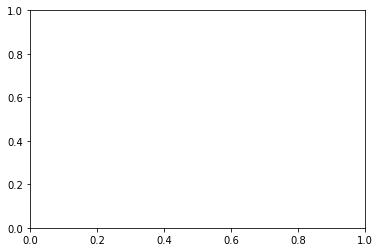

In [10]:
plt.plot(my_model.variables['m'].history, yscale='log')